In [31]:
# imports & their global configs

import os
import sys
import warnings
warnings.filterwarnings("ignore", message="Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.")

import utilities
import datanalysis as da

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import kmapper as km
from sklearn import datasets
import sklearn

from IPython.core.display import display, HTML

In [2]:
# set global vars + ipynb imports        
CWPATH = '.'
DATA_SUFFIX = '.csv' # Assume any CSV is correct data

# find other folders
MOD_DIR = utilities.findSubmoduleDir(CWPATH)
PROJ_DIR = os.path.abspath(MOD_DIR + '/..')
sys.path.insert(0, MOD_DIR+'/notebooks')

from ipynb.fs.full.data_processing import (
    is_abnormal_cxr,
    open_data, #This is being overridden
    SYMPTOMS,
    VITALS,
    COMORBIDITIES,
)

In [3]:
# read data- i want to use the one supplied but need custom path + reset_index must be true
df = utilities.open_data(MOD_DIR + '/data')

In [4]:
# Let's drop some columns we know we're not interested in.
# We're using cxr_label + cxr_impression
df = df.drop([
'test_name',
'swab_type',
'cxr_link',
'cxr_findings',
'er_referral',
], axis='columns', errors='ignore')


In [5]:
df.apply(da.printDataTypeAnalaysis, axis='index', result_type="reduce")

,batch_date,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_impression,cxr_label
missing/empty,0,0,0,169,1501,0,0,0,0,0,0,0,0,4627,4644,4618,4618,5407,4783,11004,11083,5293,4146,6658,6344,7596,15,9507,2532,206,10220,187,176,183,190,190,187,182,183,10716,10716
Has NaNs,False,False,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
inferred type,object,object,<class 'numpy.number'>,object,object,bool,bool,bool,bool,bool,bool,bool,bool,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,object,object,object,object,object,object,<class 'numpy.number'>,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
"min,max",N/A,N/A,"(-3,90)",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,"(34.95,39.4)","(40.0,150.0)","(75.0,235.0)","(36.0,135.0)","(10.0,32.0)","(76.0,100.0)",N/A,N/A,N/A,N/A,N/A,N/A,"(1.0,300.0)",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
n uniques,11,2,N/A,2,2,2,2,2,2,2,2,2,2,N/A,N/A,N/A,N/A,N/A,N/A,2,2,2,2,2,2,N/A,2,3,2,2,3,2,2,2,2,2,2,2,2,189,3


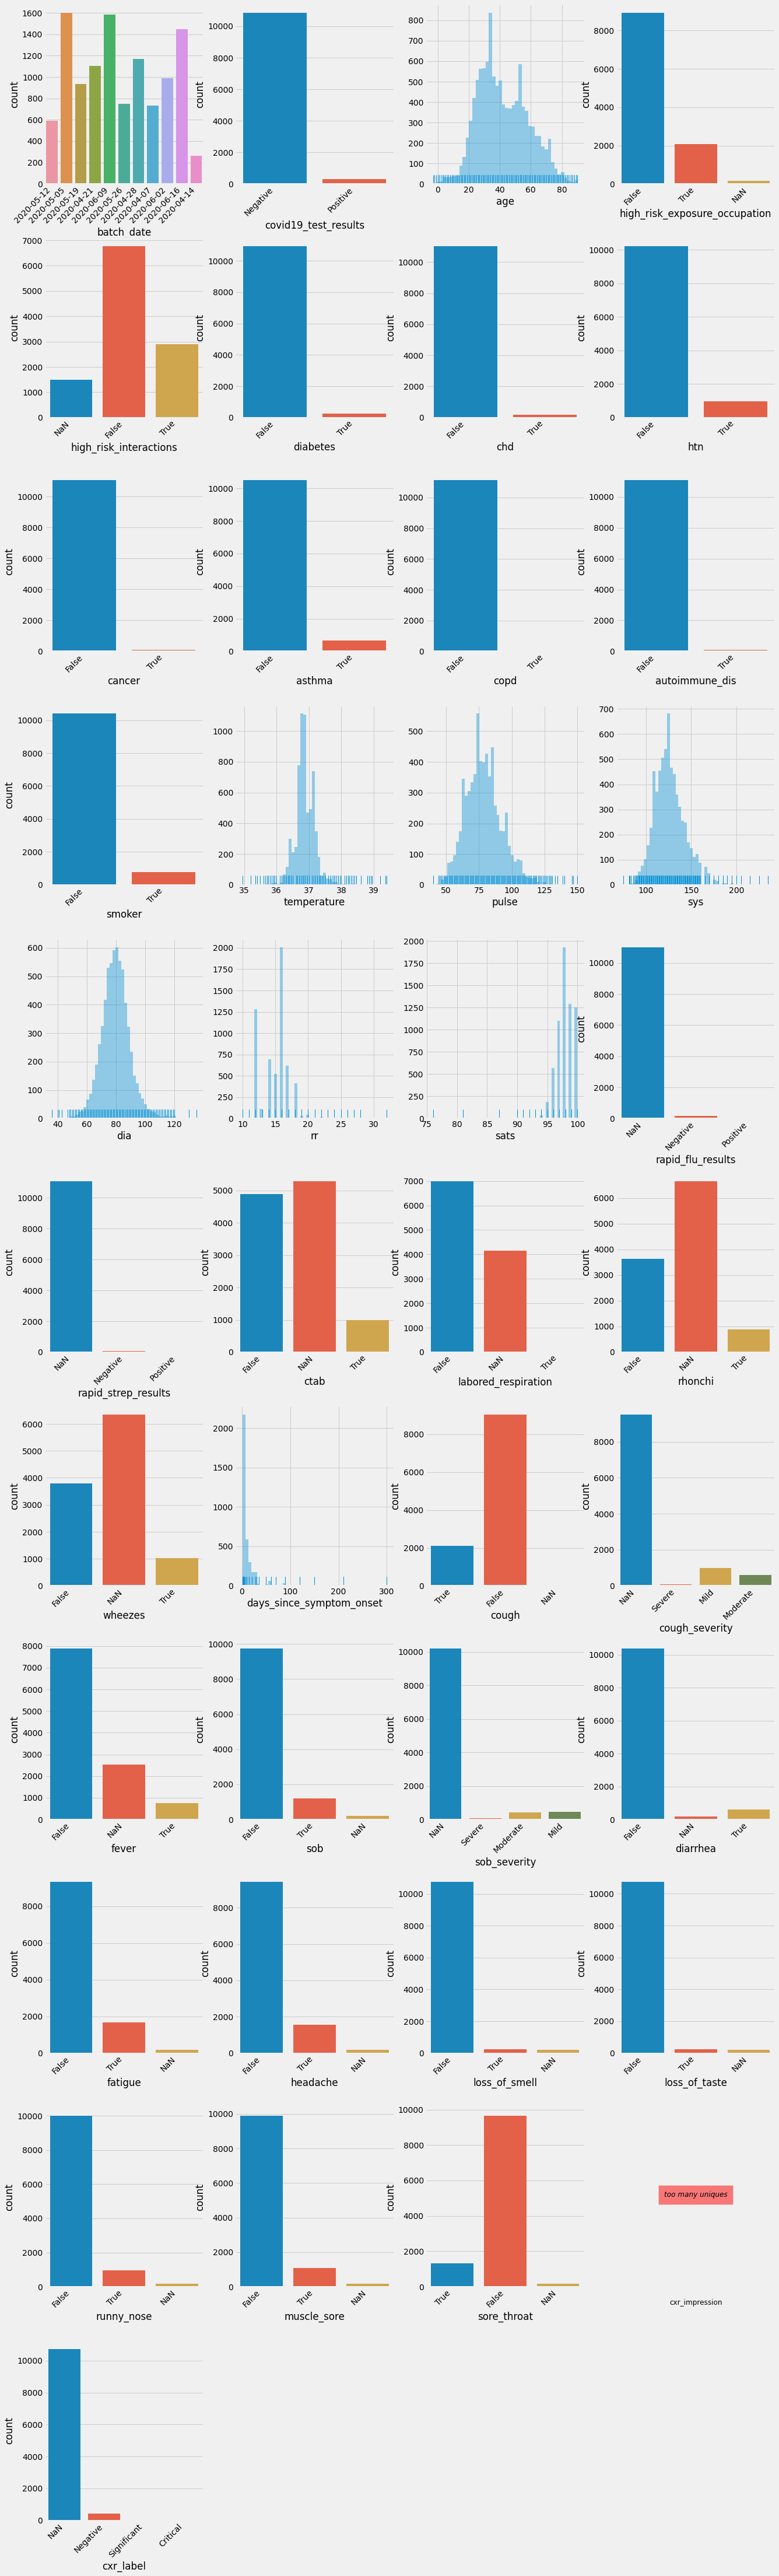

In [6]:
da.plotDataDistributions(df)

In [7]:
# numerize can take any columns whose type allows subtraction, and whose subtraction allows division, and maps it from 0->1
def numerize(column: pd.Series)-> pd.Series:
    if column.name == "index":
        return column
    low = column.min()
    width = column.max() - low
    if width == 0:
        return column
    return (column - low)/width

In [8]:
# Convert batch_date to a pandas timestamp
if not np.issubdtype(df['batch_date'].infer_objects().dtypes, np.number):
    df['batch_date'] = pd.to_datetime(df['batch_date'])

In [9]:
# Convert covid19_test_results to a number, 0 or 1
if not np.issubdtype(df['covid19_test_results'].infer_objects().dtypes, np.number):
    df['covid19_test_results'].replace({
        'Negative': 0,
        'Positive': 1,
        }, inplace=True)

In [10]:
# Remove any rows with nonsense ages
if (any(df['age'] < 0)):
    df = df[df['age'] >= 0]
    df.reset_index(inplace=True) #reset_index seems to improve the listcomps. I want to use drop=True to prevent the creation of a new column, but that breaks date arithmetic?


In [11]:
# We combine both high risk columns into one high risk column, and assume missing values are displaying high risk behavior.
if 'high_risk_exposure_occupation' in df and 'high_risk_interactions' in df:
    # check the types here
    def hr(occupations: pd.Series, interactions: pd.Series) -> int:
        if occupations == True or interactions == True:
            return 1
        if occupations == False or interactions == False:
            return 0
        else:
            return None

    combinedRiskColumn = pd.Series([ hr(occupations, interactions) for occupations, interactions in zip(df['high_risk_exposure_occupation'], df['high_risk_interactions']) ])
    # You now have four options to deal with missing values

    # Assume high-risk
    combinedRiskColumn.fillna(1, inplace=True)
    # Assume low-risk
    #combinedRiskColumn.fillna(0, inplace=True)

    # Drop rows with missing values
    #df = df[combinedRiskColumn.notna()]
    #combinedRiskColumn.dropna(inplace=True)
    #df.reset_index(inplace=True)
    # still need to add column as below

    # Or just drop the whole column by not executing the line below, maybe based on a threshhold `if combinedRiskColumn.isna().sum() > N`
    df['high_risk_combined'] = combinedRiskColumn

    df.drop([
    'high_risk_exposure_occupation',
    'high_risk_interactions'
    ], axis='columns', errors='ignore', inplace=True)

In [12]:
# Assume all comorbidities are false.
for col in COMORBIDITIES:
    df[col].fillna(False, inplace=True) 
    df[col].replace({
        False: 0,
        True: 1,
        }, inplace=True)

In [13]:
# If clinician didn't record vitals, assume patient presented normally. IE test not indicated, values likely normal for age (not great).
def typicalTemp(age: int, temperature: float) -> float:
    if not np.isnan(temperature):
        return temperature
    if age < 18:
        return 36.9
    if age < 65:
        return 36.5
    return 36.2

df['temperature'] = pd.Series([ typicalTemp(age, temperature) for age, temperature in zip(df['age'], df['temperature']) ])

In [14]:
def typicalPulse(age: int, pulse: float) -> float:
    if not np.isnan(pulse):
        return pulse
    if age < 1:
        return 120
    if age < 2:
        return 110
    if age < 6:
        return 95
    if age < 12:
        return 90
    if age < 18:
        return 80
    return 70

df['pulse'] = pd.Series([ typicalPulse(age, pulse) for age, pulse in zip(df['age'], df['pulse']) ])

In [15]:
def typicalSys(age: int, sys: float) -> float:
    if not np.isnan(sys):
        return sys
    if age < 2:
        return 100
    if age < 10:
        return 105
    if age < 29:
        return 120
    if age < 35:
        return 122
    if age < 39:
        return 123
    if age < 45:
        return 124
    if age < 49:
        return 130
    return 134

df['sys'] = pd.Series([ typicalSys(age, sys) for age, sys in zip(df['age'], df['sys']) ])

In [16]:
def typicalDia(age: int, dia: float) -> float:
    if not np.isnan(dia):
        return dia
    if age < 2:
        return 50
    if age < 10:
        return 68
    if age < 29:
        return 75
    if age < 35:
        return 80
    if age < 39:
        return 82
    if age < 45:
        return 83
    if age < 49:
        return 84
    return 85

df['dia'] = pd.Series([ typicalDia(age, dia) for age, dia in zip(df['age'], df['dia']) ])

In [17]:
def typicalRR(age: int, rr: float) -> float:
    if not np.isnan(rr):
        return rr
    if age < 1:
        return 35
    if age < 3:
        return 25
    if age < 6:
        return 22
    if age < 10:
        return 20
    if age < 65:
        return 15
    if age < 80:
        return 18
    return 20

df['rr'] = pd.Series([ typicalRR(age, rr) for age, rr in zip(df['age'], df['rr']) ])

In [18]:
def typicalSATS(age: int, sats: float) -> float:
    if not np.isnan(sats):
        return sats
    if age < 18:
        return 98
    if age < 70:
        return 97
    return 95

df['sats'] = pd.Series([ typicalSATS(age, sats) for age, sats in zip(df['age'], df['sats']) ])

In [19]:
# Combine counter indicators (flu+strep) into one column and assume negative (IE no reason to test = negative test)
if 'rapid_flu_results' in df and 'rapid_strep_results' in df:
    # check the types here
    def ci(flu: pd.Series, strep: pd.Series) -> int:
        if flu == "Positive" or strep == "Positive":
            return 1
        else:
            return 0

    counter_indicator = pd.Series([ ci(flu, strep) for flu, strep in zip(df['rapid_flu_results'], df['rapid_strep_results']) ])
    df['counter_indicator'] = counter_indicator

    df = df.drop([
    'rapid_flu_results',
    'rapid_strep_results'
    ], axis='columns', errors='ignore')

In [20]:
# Fix Lung Sounds
# This is a bit weird because the three conditions are similiar indicators, and kind of redundant with ctab, which means "no problem"
# (clear to auscultation bilaterally)
# It's not combined into one column, but it's assumed clear, and if any sound is present, CTAB needs to be false
if 'ctab' in df:
    # check the types here
    def fix_ctab(ctab: pd.Series, labored_respiration: pd.Series, rhonchi: pd.Series, wheezes: pd.Series) -> int:
        if ctab == False or labored_respiration == True or rhonchi == True or wheezes == True:
            if ctab == True:
                # Weird, but common in this data? Cannot be true if any ethers are true
                pass
            return 0
        return 1

    df['ctab'] = pd.Series([ fix_ctab(ctab, labored_respiration, rhonchi, wheezes) 
                            for ctab, labored_respiration, rhonchi, wheezes 
                            in zip(df['ctab'], df['labored_respiration'], df['rhonchi'], df['wheezes']) ])
    
    for col in ["labored_respiration", "rhonchi", "wheezes"]:
        df[col].fillna(False, inplace=True) 
        df[col].replace({
            False: 0,
            True: 1,
            }, inplace=True)

In [21]:
# Combine symptom severness and presence into one column and assume no symptom is not recorded
for col in ["diarrhea", "fever", "headache", "fatigue", "loss_of_smell", "loss_of_taste", "runny_nose", "muscle_sore", "sore_throat"]:
    df[col].fillna(False, inplace=True) 
    df[col].replace({
        False: 0,
        True: 1,
        }, inplace=True)

In [22]:
if 'sob' in df:
    # check the types here
    def fix_sob(sob: pd.Series, sob_severity: pd.Series) -> int:
        if sob != True and type(sob_severity) == float:
            return 0
        if sob_severity == "Severe":
            return 3
        if sob_severity == "Moderate":
            return 2
        if sob_severity == "Mild":
            return 1
        if sob == True:
            return 2
        print("Shit")
    
    df['sob_severity'] = pd.Series([ fix_sob(sob, sob_severity) 
                            for sob, sob_severity 
                            in zip(df['sob'], df['sob_severity']) ])
    df = df.drop([
    'sob',
    ], axis='columns', errors='ignore')

In [23]:
if 'cough' in df:
    # check the types here
    def fix_cough(cough: pd.Series, cough_severity: pd.Series) -> int:
        if cough != True and type(cough_severity) == float:
            return 0
        if cough_severity == "Severe":
            return 3
        if cough_severity == "Moderate":
            return 2
        if cough_severity == "Mild":
            return 1
        if cough == True:
            return 2


    df['cough_severity'] = pd.Series([ fix_cough(cough, cough_severity) 
                            for cough, cough_severity 
                            in zip(df['cough'], df['cough_severity']) ])
    df = df.drop([
    'cough',
    ], axis='columns', errors='ignore')

In [24]:
# combined cxr impression and label into one column.
if 'cxr_impression' in df:
    # check the types here
    def fix_cxr(imp: pd.Series, label: pd.Series) -> int:
        if label == "Significant":
            return 1
        if label == "Critical":
            return 2
        if type(imp) != str:
            return 0
        if is_abnormal_cxr(imp) == True:
            return 1
        return 0

    df['cxr_label'] = pd.Series([ fix_cxr(imp, label) 
                            for imp, label 
                            in zip(df['cxr_impression'], df['cxr_label']) ])
    df = df.drop([
    'cxr_impression',
    ], axis='columns', errors='ignore')

In [25]:
# :-/ This data is incomplete, we should probably get rid of this column instead of using the mean.
df['days_since_symptom_onset'].fillna(df['days_since_symptom_onset'].mean(), inplace=True)

In [26]:
df = df.apply(numerize, axis=0)
# you could do this earlier or inside the rebuild_index() function called after dropping non-sense ages
# however, apply seems to change behavior depending on whether or not there is an index column ontop of the internal dataframe index
df.drop('index', axis=1, inplace=True)

In [27]:
df.apply(da.printDataTypeAnalaysis, axis='index', result_type="reduce")

,batch_date,covid19_test_results,age,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough_severity,fever,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_label,high_risk_combined,counter_indicator
missing/empty,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Has NaNs,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
inferred type,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>,<class 'numpy.number'>
"min,max","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)","(0.0,1.0)"
n uniques,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


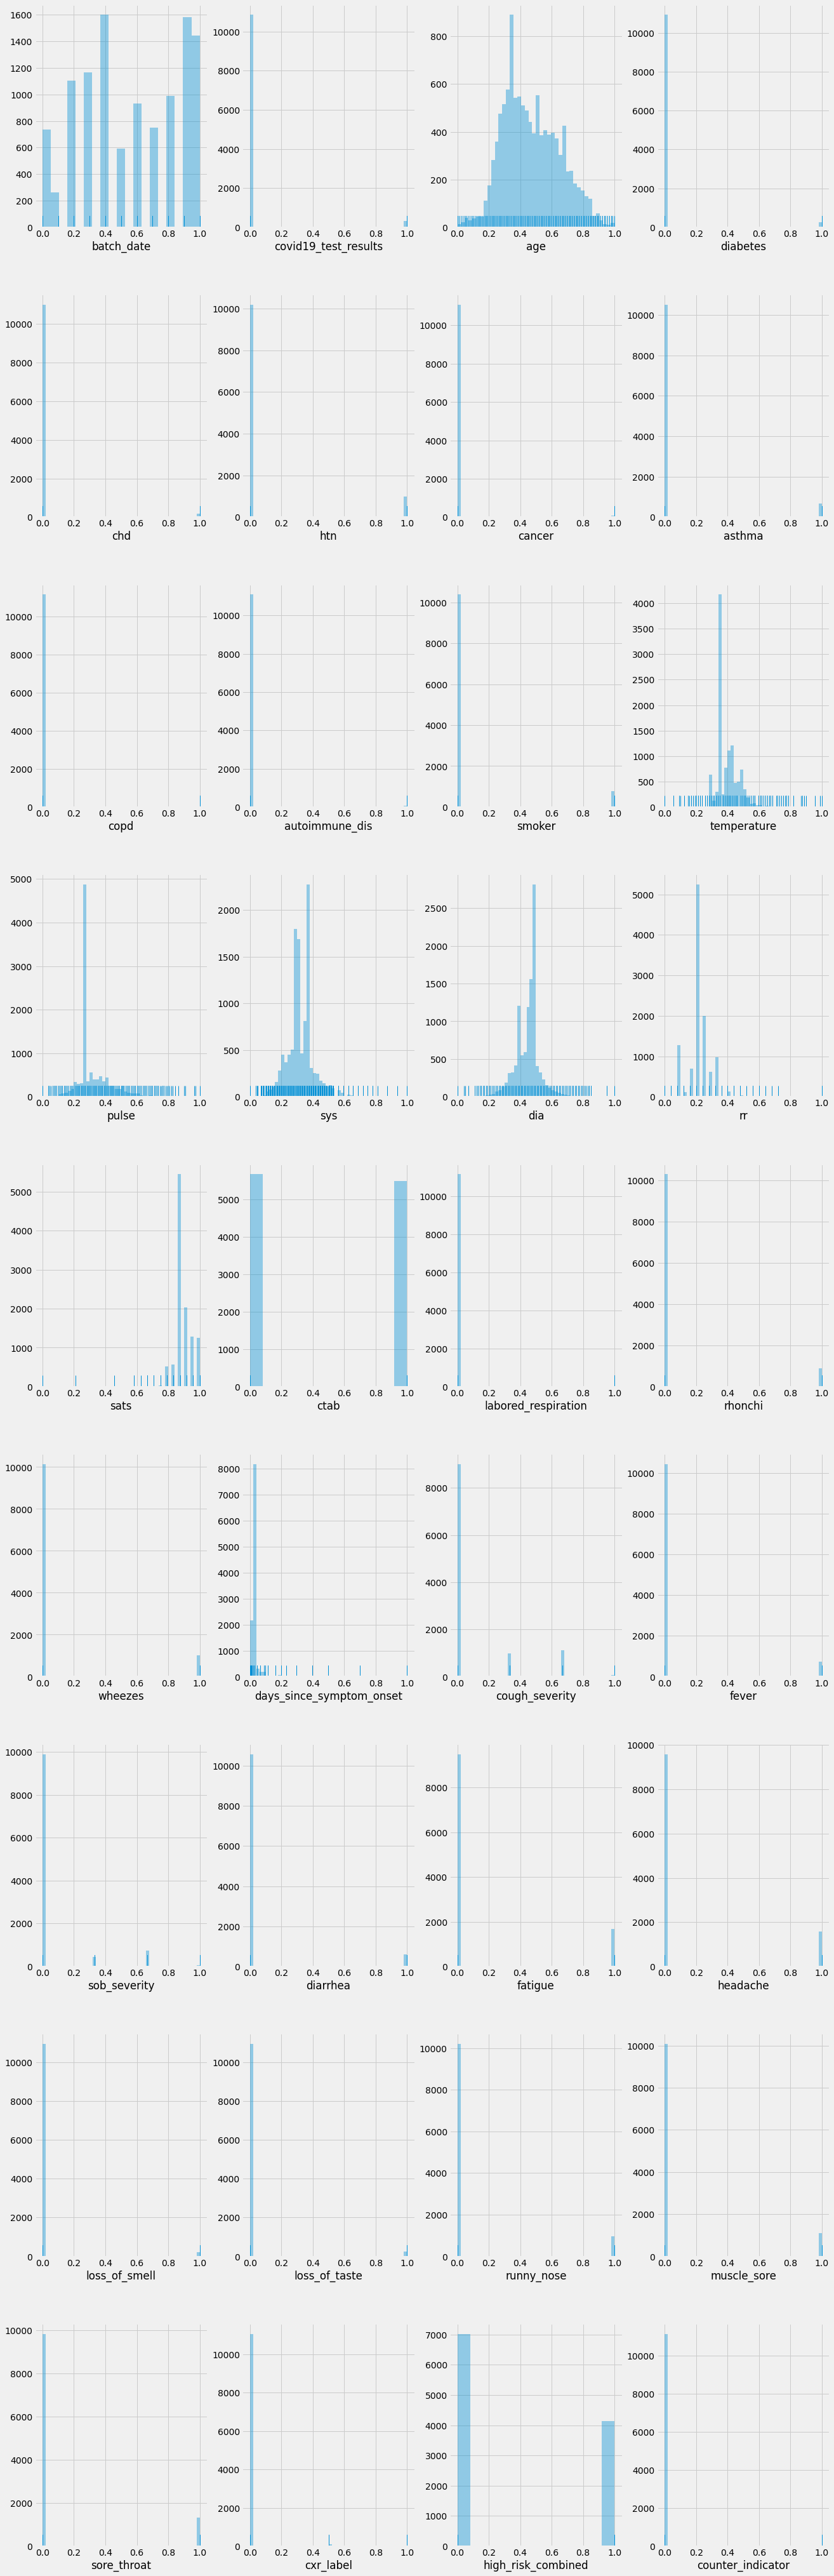

In [28]:
da.plotDataDistributions(df)

In [29]:
distances = pairwise_distances(df) # why did I have to import the function name directly from scikit?

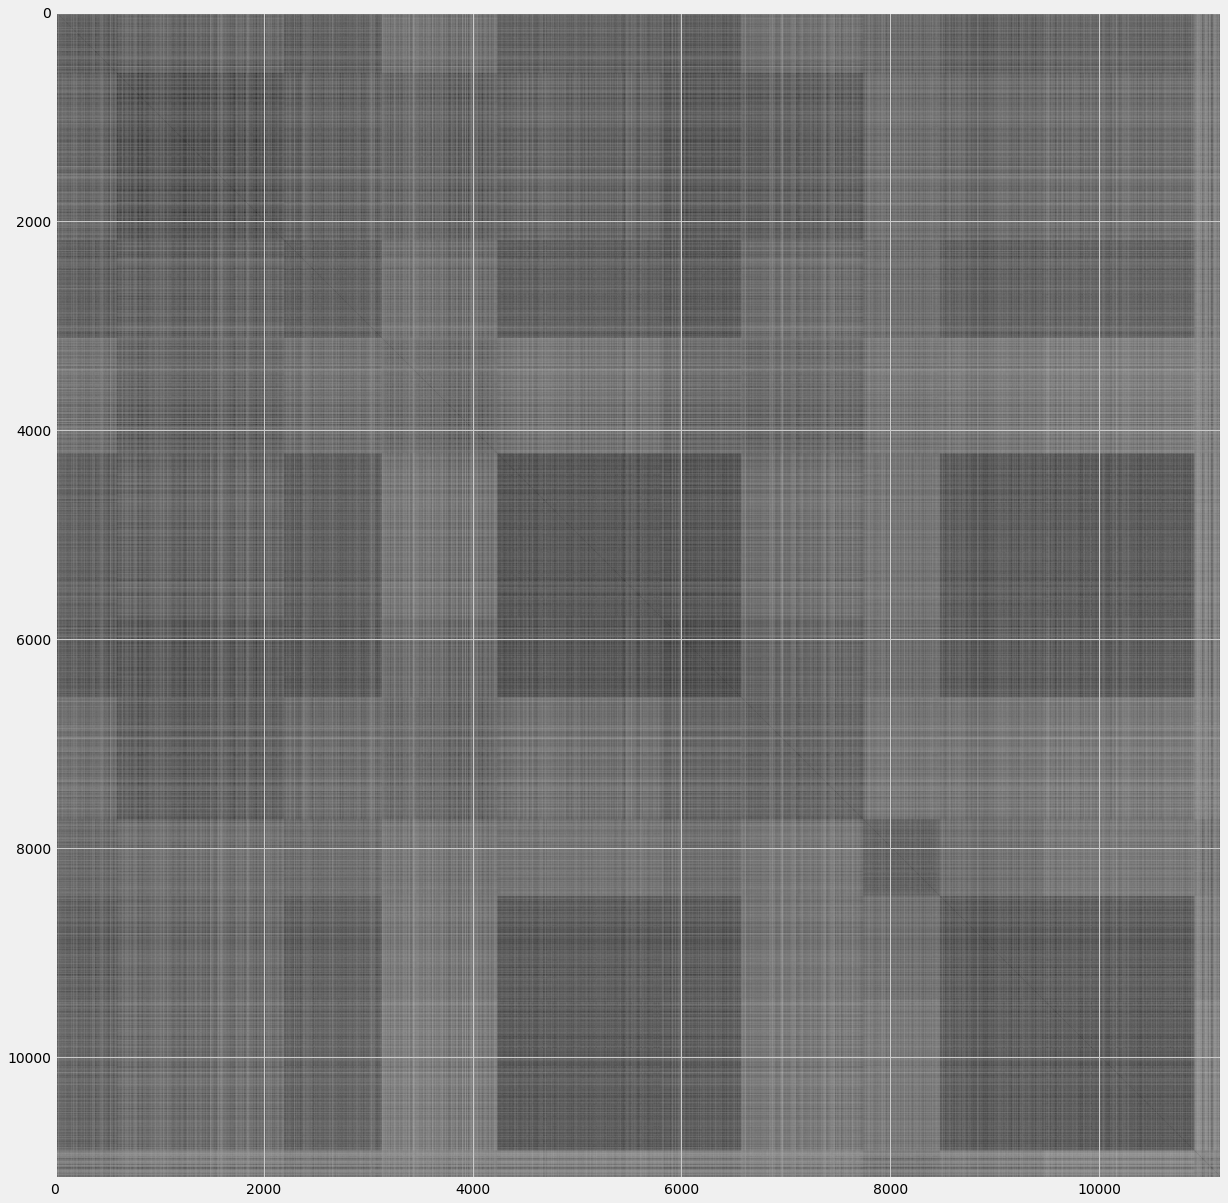

In [30]:
da.plotDistances(distances)

In [45]:
# First we build a lens. I supply a distance_matrx to the fit_transform method, but there are many techniques described to do this in the kmapper docs.
# If you don't use a distance matrix, you need df.to_numpy() I think.
# From https://kepler-mapper.scikit-tda.org/generated/gallery/plot_digits.html:
# projected_data = mapper.fit_transform(data, projection=sklearn.manifold.TSNE())
# https://kepler-mapper.scikit-tda.org/generated/gallery/plot_breast_cancer.html has a very complicated lens.
# lens = mapper.fit_transform(data) is from https://kepler-mapper.scikit-tda.org/generated/gallery/plot_cat.html
# https://kepler-mapper.scikit-tda.org/notebooks/Cancer-demo.html "choose a lens"
lens = mapper.fit_transform(distances, distance_matrix=True)

# Here we choose our clustering algorithm as well as our cover. You can use any clustering algorithm in scikit, apparently. You also supply the original data.
# Some info on cover here: https://kepler-mapper.scikit-tda.org/reference/stubs/kmapper.Cover.html#kmapper.Cover
# Apparently color, shape, and size of nodes should be configurable. It would be interested to do like, color by age, shape by covid positive/falsity, size by size. Etc.
graph = mapper.map(lens, df, clusterer=sklearn.cluster.DBSCAN(eps=0.8, min_samples=5), cover=km.Cover(n_cubes=10, perc_overlap=0.05))

# Output to a file: you can navigate to it locally in your web browser- for me it's file:///home/ajp/projects/ayjayt.github.io/notebooks/output.html
_ = mapper.visualize(graph, path_html="output.html")

..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: True
	Scalers: MinMaxScaler()
..Projecting on data shaped (11165, 11165)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (11165, 36) using lens shaped (11165, 1)

Minimal points in hypercube before clustering: 5
Creating 10 hypercubes.
   > Found 4 clusters.

   > Found 41 clusters.

   > Found 81 clusters.

   > Found 62 clusters.

   > Found 16 clusters.

   > Found 2 clusters.

   > Found 0 clusters.

   > Found 0 clusters.

   > Found 0 clusters.

   > Found 0 clusters.


Created 41 edges and 206 nodes in 0:00:03.534817.
Wrote visualization to: output.html
